In [1]:
# Some libraries installation
! git clone https://github.com/tejaslodaya/timeseries-clustering-vae.git
! pip install tslearn
! pip uninstall scikit-learn --yes 
! pip install scikit-learn==0.24.1

Cloning into 'timeseries-clustering-vae'...


Found existing installation: scikit-learn 0.24.1
Uninstalling scikit-learn-0.24.1:
  Successfully uninstalled scikit-learn-0.24.1
  Using cached scikit_learn-0.24.1-cp38-cp38-win_amd64.whl (6.9 MB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram
from tqdm.autonotebook import tqdm

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

SEED=23

<ipython-input-2-e7df5f9f222d>:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [13]:
# Data Reading 
data = pd.read_csv('data_train2.csv', delimiter=";")
data['total_penjualan'].unique()
# data.head()

array(['0.0', '4.0', '1.0', ..., '974.098', '324.293', '69.116'],
      dtype=object)

In [16]:
data.to_csv('input.csv', index=False)

##### ganti data

In [34]:
import random
# Read the CSV file into a DataFrame
data = pd.read_csv('input.csv')

# Delete the "total_penjualan" column
data.drop('total_penjualan', axis=1, inplace=True)

# Generate new data for the "total_penjualan" column
new_values = [random.uniform(0, 1000) for _ in range(len(data))]
data['total_penjualan'] = new_values

# Save the modified DataFrame back to the CSV file
data.to_csv('modified_datas.csv', index=False)

In [40]:
# Change the value "c" to "d" in the "nama_marketplace" column
data['nama_marketplace'] = data['nama_marketplace'].replace('3', 'bukalapak')

# Save the modified DataFrame back to the CSV file
data.to_csv('modified_datas.csv', index=False)

In [3]:
# Data Reading 
data = pd.read_csv('modified_datas.csv')
# data['nama_marketplace'].unique()
data.head()

id   ket_waktu nama_marketplace       jenis_barang  status_promosi  \
0   1  2013-01-01           Lazada           Otomotif               0   
1   2  2013-01-01           Lazada  Perlengkapan Bayi               0   
2   3  2013-01-01           Lazada  Produk Kecantikan               0   
3   4  2013-01-01           Lazada            Minuman               0   
4   5  2013-01-01           Lazada     Buku dan Novel               0   

   total_penjualan  
0       809.148243  
1       647.504899  
2       312.767869  
3       946.490214  
4       936.897775

--------------------------------------------------

In [4]:
data.dtypes

id                    int64
ket_waktu            object
nama_marketplace     object
jenis_barang         object
status_promosi        int64
total_penjualan     float64
dtype: object

In [6]:
# # Convert 'ket_waktu' column to datetime
data['ket_waktu'] = pd.to_datetime(data['ket_waktu'])

# # Convert 'total_penjualan' column to float
# data['total_penjualan'] = data['total_penjualan'].astype(float)


# # Check the updated data types
# print(data.dtypes)

In [7]:
data.tail()

id  ket_waktu nama_marketplace           jenis_barang  \
77710  77711 2014-08-13        bukalapak           Daging Putih   
77711  77712 2014-08-13        bukalapak                Kuliner   
77712  77713 2014-08-13        bukalapak     Peralatan Olahraga   
77713  77714 2014-08-13        bukalapak  Alat Tulis dan Kantor   
77714  77715 2014-08-13        bukalapak             Hasil Laut   

       status_promosi  total_penjualan  
77710               1       530.340127  
77711               0        51.639234  
77712               1       107.750114  
77713               0       563.714798  
77714               0       678.257628

In [8]:
print('Number of Unique Stores: ', data['nama_marketplace'].unique().shape[0])
print('Unique Product Categories: ', data['jenis_barang'].unique().shape[0])

Number of Unique Stores:  5
Unique Product Categories:  32


In [9]:
# Make sure that each store has all these unique product categories
assert data.groupby(['nama_marketplace', 'jenis_barang']).size().shape[0] == 5*32

In [10]:
# Time Series data for finding similar stores
store_sales = data.groupby(['ket_waktu', 'nama_marketplace'], as_index=False).aggregate({'total_penjualan': 'sum'})

# Time Series data for finding similar product categories
product_sales = data.groupby(['ket_waktu', 'nama_marketplace', 'jenis_barang'], as_index=False).aggregate({'total_penjualan': 'sum'})

In [11]:
# Check if we have stores with zero sales 
stores_to_drop = []
for store in store_sales['nama_marketplace'].unique():
    if (store_sales.query(f"nama_marketplace == '{store}'")['total_penjualan'] == 0).all():
        stores_to_drop.append(store)
        
print('Stores with no sales: ', stores_to_drop)

# Exlude these stores
store_sales = store_sales[~store_sales['nama_marketplace'].isin(stores_to_drop)]

Stores with no sales:  []


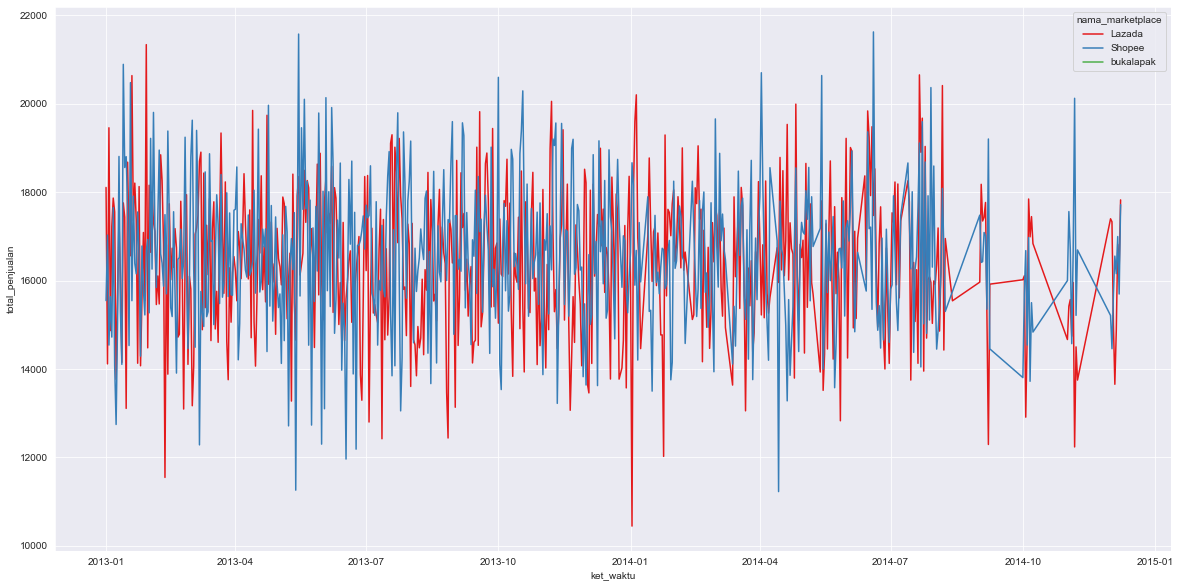

In [12]:
# Let's have a look at 5 different stores 
# become 3 bcs we have like 5
rand_stores = np.random.choice(store_sales['nama_marketplace'].unique(), 5)
selected_stores = store_sales[store_sales['nama_marketplace'].isin(rand_stores)][['ket_waktu', 'nama_marketplace', 'total_penjualan']]

plt.figure(figsize=(20,10))
plt.grid(True)
sns.lineplot(data=selected_stores, x='ket_waktu', y='total_penjualan', hue='nama_marketplace', ci=False, legend=True, palette='Set1');

In [13]:
# Find noisy series 
store_to_drop = []
for store in store_sales['nama_marketplace'].unique():
    current_store = store_sales.query(f"nama_marketplace == '{store}'")
    if current_store.query('total_penjualan == 0').shape[0]/current_store.shape[0] > 0.3:
        store_to_drop.append(store)
        
print('Noisy Stores: ', store_to_drop)

# Drop noisy stores
store_sales = store_sales[~store_sales['nama_marketplace'].isin(store_to_drop)]

Noisy Stores:  []


In [14]:
# First convert zero values to NaN
store_sales['total_penjualan'] = store_sales['total_penjualan'].apply(lambda x: np.nan if x == 0 else x)

# Fill missing values 
res_df = pd.DataFrame()
for store in store_sales['nama_marketplace'].unique():
    current_store = store_sales.query(f"nama_marketplace == '{store}'")
    # Use interpolation to fill values between dates
    current_store['total_penjualan'].interpolate(method ='linear', limit_direction ='forward', inplace=True)
    # Some stores probably were closed on 01-01-YYYYY, fill it by the value on the next day
    current_store['total_penjualan'].fillna(method ='bfill', inplace=True)
    res_df = res_df.append(current_store)
    
store_sales = res_df

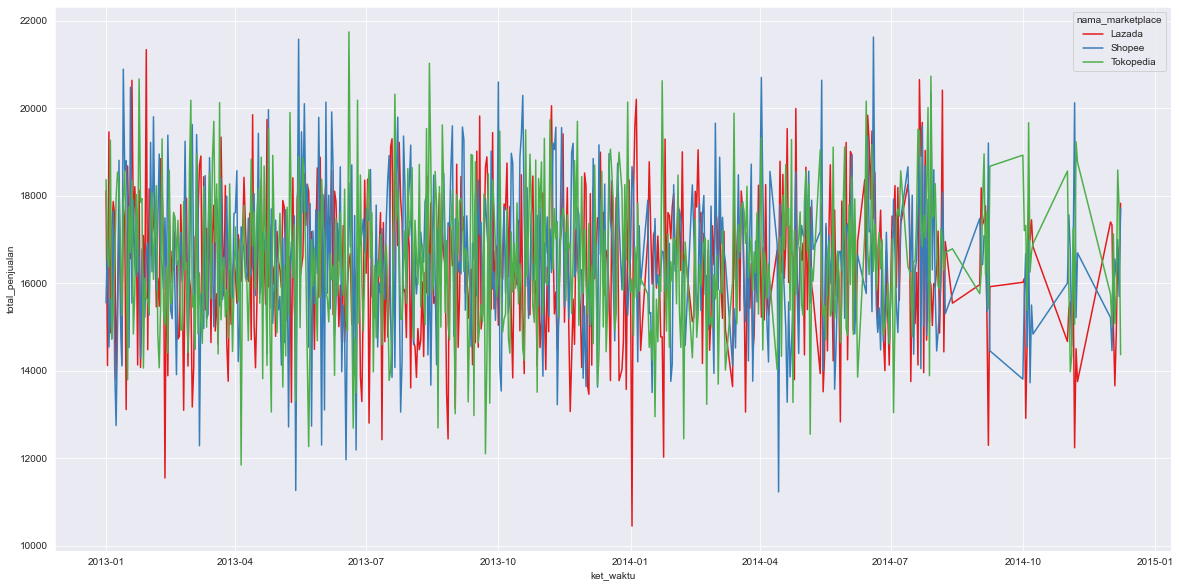

In [15]:
# Let's have a look at 5 different stores 
rand_stores = np.random.choice(store_sales['nama_marketplace'].unique(), 3)
selected_stores = store_sales[store_sales['nama_marketplace'].isin(rand_stores)][['ket_waktu', 'nama_marketplace', 'total_penjualan']]

plt.figure(figsize=(20,10))
plt.grid(True)
sns.lineplot(data=selected_stores, x='ket_waktu', y='total_penjualan', hue='nama_marketplace', ci=False, legend=True, palette='Set1');

#### Time Series Smoothing

In [16]:
#Time Series Smoothing 
res_df = pd.DataFrame()
for store in store_sales['nama_marketplace'].unique():
    current_store = store_sales.query(f"nama_marketplace == '{store}'")
    current_store['smoth_7'] = current_store['total_penjualan'].rolling(7).mean()
    res_df = res_df.append(current_store[['ket_waktu', 'nama_marketplace', 'smoth_7']])
    
store_sales = res_df
store_sales = store_sales.dropna()

In [17]:
# # Time Series Smoothing 
# res_df = pd.DataFrame()
# for store in store_sales['nama_marketplace'].unique():
#     current_store = store_sales.query(f"nama_marketplace == '{store}'")
#     #ini yg kutambahin
#     current_store['total_penjualan'] = pd.to_numeric(current_store['total_penjualan'], errors='coerce')  # Convert ke numeric
#     current_store['smoth_7'] = current_store['total_penjualan'].rolling(7).mean()
#     res_df = res_df.append(current_store[['ket_waktu', 'nama_marketplace', 'smoth_7']])

# store_sales = res_df
# store_sales = store_sales.dropna()

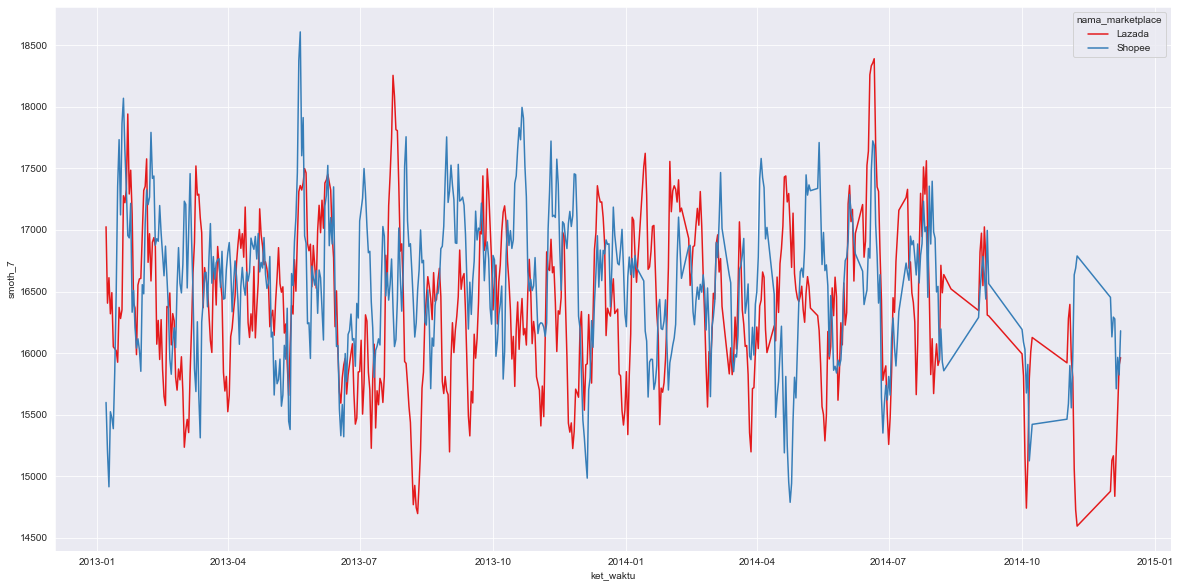

In [18]:
# Let's have a look at 3 different stores 
rand_stores = np.random.choice(store_sales['nama_marketplace'].unique(), 3)
selected_stores = store_sales[store_sales['nama_marketplace'].isin(rand_stores)][['ket_waktu', 'nama_marketplace', 'smoth_7']]

plt.figure(figsize=(20,10))
plt.grid(True)
sns.lineplot(data=selected_stores, x='ket_waktu', y='smoth_7', hue='nama_marketplace', ci=False, legend=True, palette='Set1');

In [28]:
# Feature matrix with shape (n_series x time_observations)
series_df = store_sales.pivot(index='nama_marketplace', columns='ket_waktu', values='smoth_7')
series_df = series_df.dropna(axis='columns')
series_df.head()

ket_waktu           2013-01-07    2013-01-08    2013-01-09    2013-01-10  \
nama_marketplace                                                           
Blibli            16531.889150  16535.953634  16749.978889  16563.497612   
Lazada            17025.888930  16405.925631  16612.334086  16319.723494   
Shopee            15600.030315  15199.827478  14915.523536  15524.701948   
Tokopedia         16725.113457  16667.246240  16945.781744  17210.891376   

ket_waktu           2013-01-11    2013-01-12    2013-01-13    2013-01-14  \
nama_marketplace                                                           
Blibli            16609.100832  17051.129867  17060.693176  16958.117456   
Lazada            16491.103507  16052.338955  16036.768963  16020.316493   
Shopee            15475.484672  15387.436663  15850.350737  16489.687144   
Tokopedia         16872.814304  16948.633390  17310.365799  17621.582501   

ket_waktu           2013-01-15    2013-01-16  ...    2014-11-07    2014-11-08  \
nama_marketplace                              ...                               
Blibli            16813.815671  16452.757008  ...  18106.903875  18016.027598   
Lazada            15926.624488  16371.695831  ...  14727.599387  14596.648829   
Shopee            17354.665540  17732.929680  ...  16689.979122  16789.029714   
Tokopedia         17448.877623  16770.963192  ...  16336.156106  16365.460877   

ket_waktu           2014-12-01    2014-12-02    2014-12-03    2014-12-04  \
nama_marketplace                                                           
Blibli            17995.683763  18071.972529  18179.141290  17832.129763   
Lazada            14878.909771  15130.334275  15167.075365  14838.376392   
Shopee            16453.424056  16132.287915  16292.762784  16277.791001   
Tokopedia         16341.196105  16490.649920  16886.667518  16575.137547   

ket_waktu           2014-12-05    2014-12-06    2014-12-07    2014-12-08  
nama_marketplace                                                          
Blibli            17080.120147  17099.921689  16754.536485  17214.541705  
Lazada            15213.527205  15544.489407  15902.967676  15964.012140  
Shopee            15711.384935  15965.924637  15823.543790  16181.455847  
Tokopedia         16673.921855  16581.752811  16422.227434  16225.160831  

[4 rows x 582 columns]

### Modeling

In [20]:
# Scaling
scaler = StandardScaler()

# First transposition - to have series in columns (allows scaling each series independently)
# Second Transposition - come back to initial feature matrix shape (n_series x time_observations)
scaler = StandardScaler()
scaled_ts = scaler.fit_transform(series_df.T).T 

In [21]:
# Run KMeans and plot the results 
def get_kmeans_results(data, max_clusters=3, metric='euclidean', seed=23):
    """
    Runs KMeans n times (according to max_cluster range)

    data: pd.DataFrame or np.array
        Time Series Data
    max_clusters: int
        Number of different clusters for KMeans algorithm
    metric: str
        Distance metric between the observations
    seed: int
        random seed
    Returns: 
    -------
     None      
    """
    # Main metrics
    distortions = []
    silhouette = []
    clusters_range = range(1, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=-1, max_iter=10, random_state=seed)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)
        if K > 1:
            silhouette.append(silhouette_score(data, kmeans_model.labels_))
            
    # Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[1:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette');


Wall time: 3.52 s


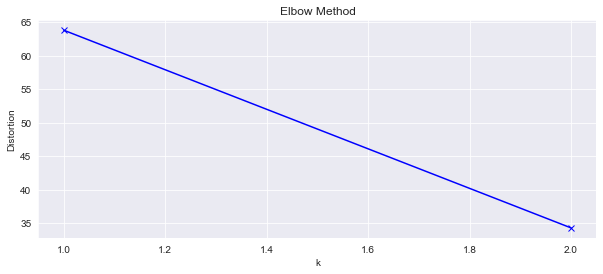

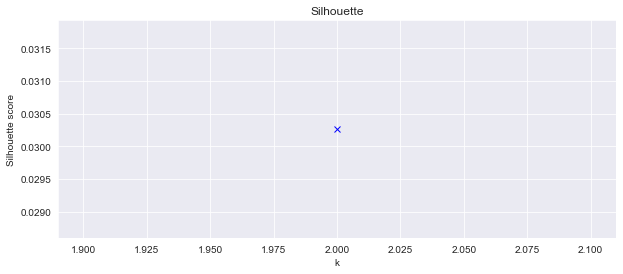

In [22]:
%%time

# Run the algorithm using DTW algorithm 
get_kmeans_results(data=scaled_ts, max_clusters=2, metric='dtw', seed=SEED)

In [23]:
# Visualization for obtained clusters   
def plot_clusters(data, cluster_model, dim_red_algo):
    """
    Plots clusters obtained by clustering model 

    data: pd.DataFrame or np.array
        Time Series Data
    cluster_model: Class
        Clustering algorithm 
    dim_red_algo: Class
        Dimensionality reduction algorithm (e.g. TSNE/PCA/MDS...) 
    Returns:
    -------
    None
    """
    cluster_labels = cluster_model.fit_predict(data)
    centroids = cluster_model.cluster_centers_
    u_labels = np.unique(cluster_labels)
    
    # Centroids Visualization
    plt.figure(figsize=(16, 10))
    plt.scatter(centroids[:, 0] , centroids[:, 1] , s=150, color='r', marker="x")
    
    # Downsize the data into 2D
    if data.shape[1] > 2:
        data_2d = dim_red_algo.fit_transform(data)
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)
    else:
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)

    plt.title('Clustered Data')
    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")
    plt.grid(True)
    plt.legend(title='Cluster Labels');

Wall time: 956 ms


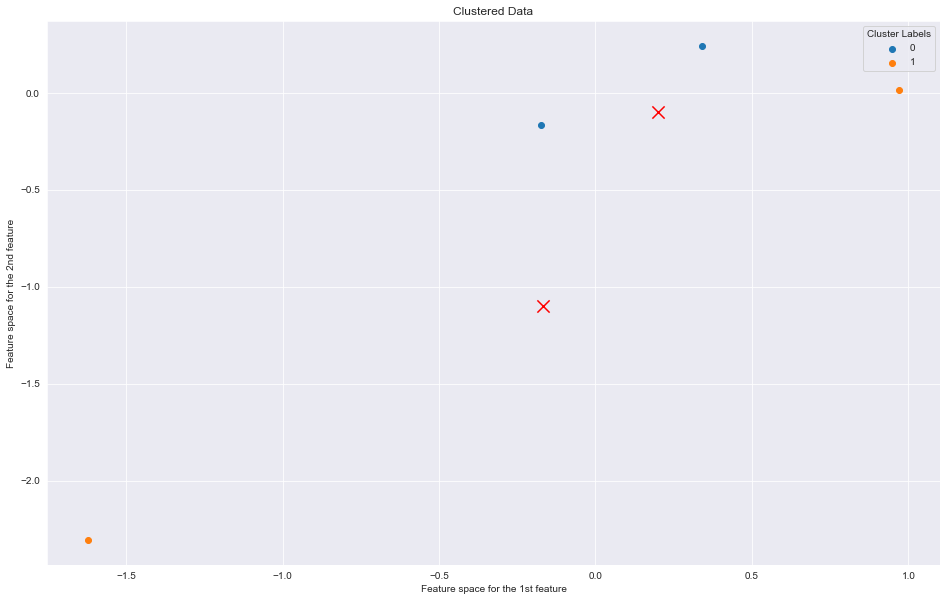

In [24]:
%%time

# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=2, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=scaled_ts,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

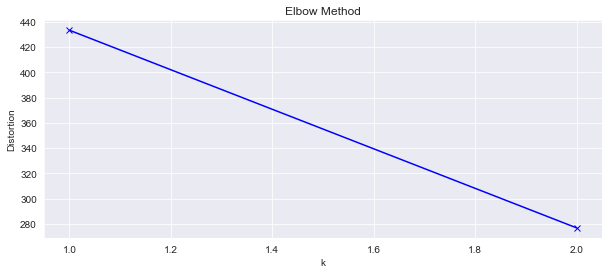

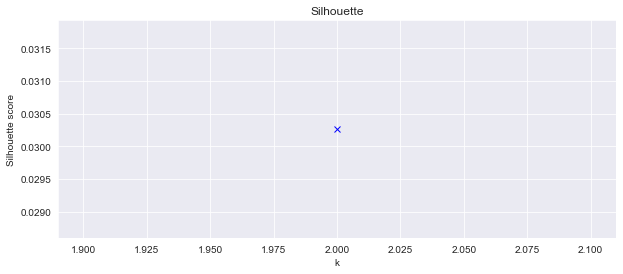

In [25]:
# let's compare with the euclidean metric
get_kmeans_results(data=scaled_ts, max_clusters=2, metric='euclidean', seed=SEED)

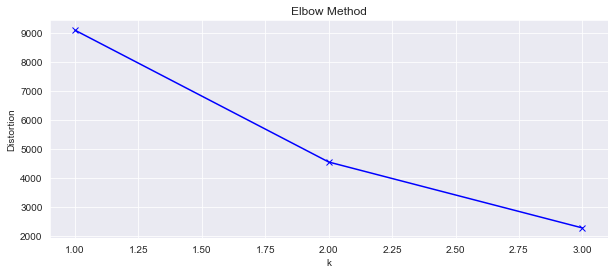

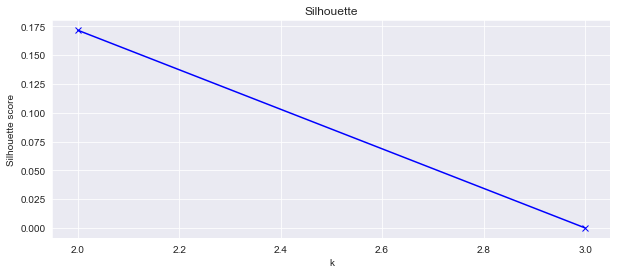

In [29]:
# Downsize the features into 2D
tsne = TSNE(n_components=2, init='pca', random_state=SEED)
data_tsne = tsne.fit_transform(scaled_ts)

get_kmeans_results(data=data_tsne, max_clusters=3, metric='euclidean', seed=SEED)

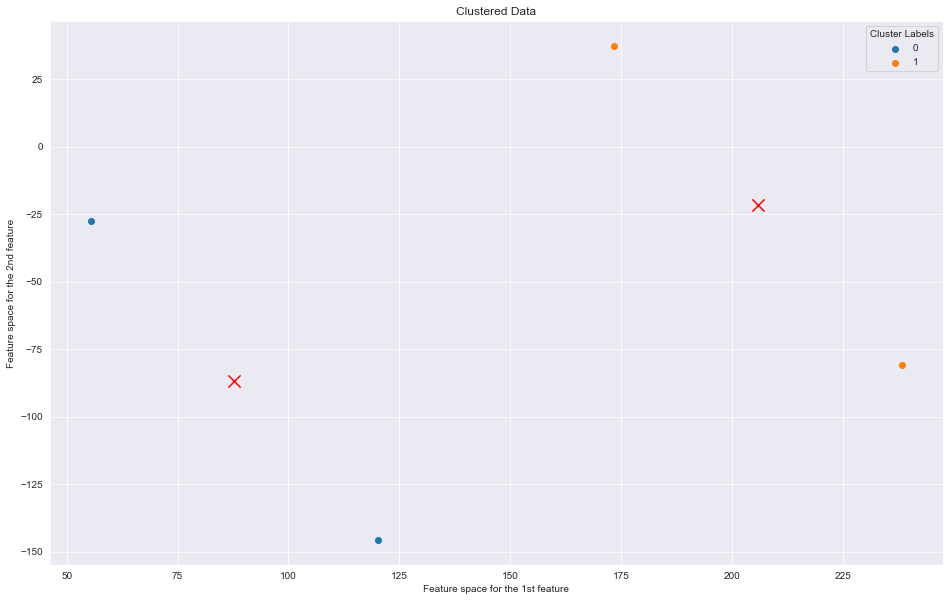

In [31]:
# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=2, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_tsne,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

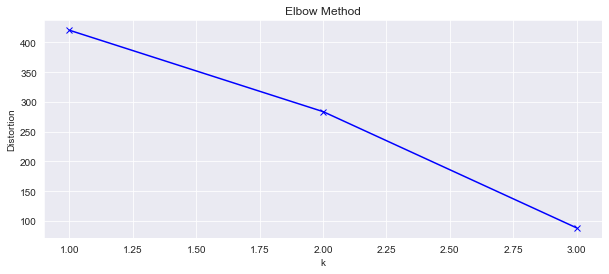

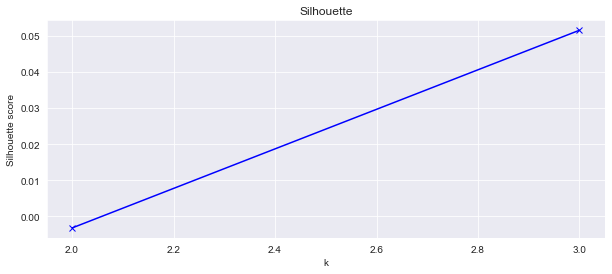

In [32]:
mds = MDS(n_components=2, n_init=3, max_iter=100, random_state=SEED)
data_mds = mds.fit_transform(scaled_ts) 

get_kmeans_results(data=data_mds, max_clusters=3, metric='euclidean', seed=SEED)

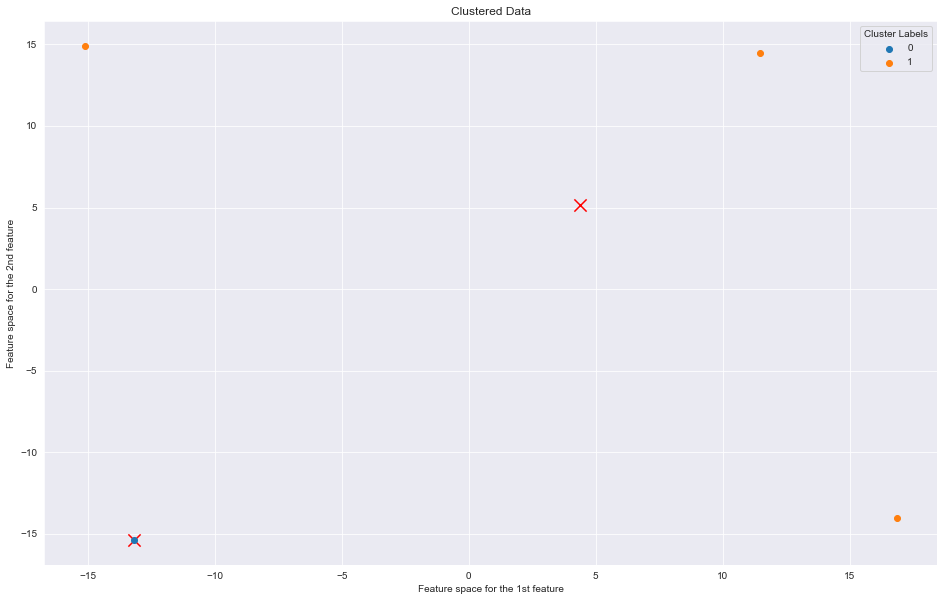

In [33]:
# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=2, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_mds,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

In [34]:
# HAC clustering (similar to get_kmeans_results function)
def get_hac_results(data, max_clusters=3, linkage='euclidean', seed=23):
    silhouette = []
    clusters_range = range(2, max_clusters+1)
    for K in tqdm(clusters_range):
        model = AgglomerativeClustering(n_clusters=K, linkage=linkage)
        model.fit(data)
        silhouette.append(silhouette_score(data, model.labels_))
        
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette')
    plt.grid(True);

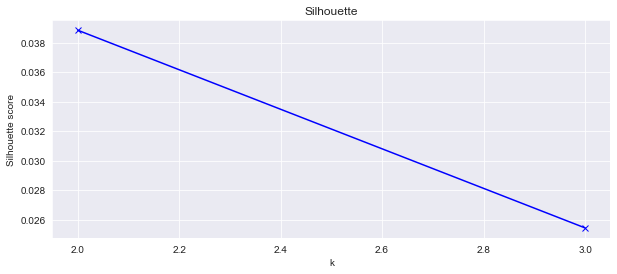

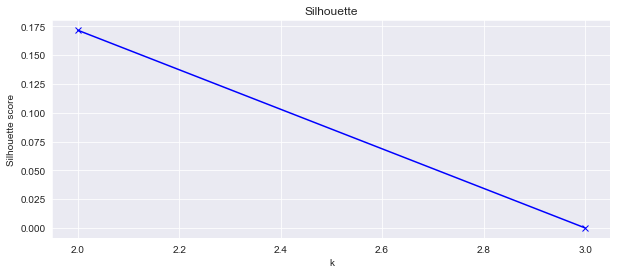

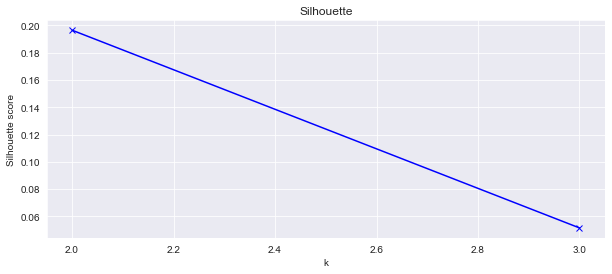

In [35]:
# Look at all results at a time 
features_df = [scaled_ts, data_tsne, data_mds]
for df in features_df:
    get_hac_results(data=df, max_clusters=3, linkage='ward', seed=SEED)

In [36]:
def plot_dendrogram(data, model, figsize=(16,10), **kwargs):
    """
    Plots a dendogram using HAC 

    data: pd.DataFrame or np.array
        Time Series Data
    model: Class
        Clustering Model 
    figsize: tuple
        Figure size
    Returns:
    -------
    None 
    """
    model.fit(data)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
    plt.figure(figsize=figsize, dpi=200)
    dendrogram(linkage_matrix, **kwargs)
    plt.title('Dendogram')
    plt.xlabel('Objects')
    plt.ylabel('Distance')
    plt.grid(False)
    plt.tight_layout();

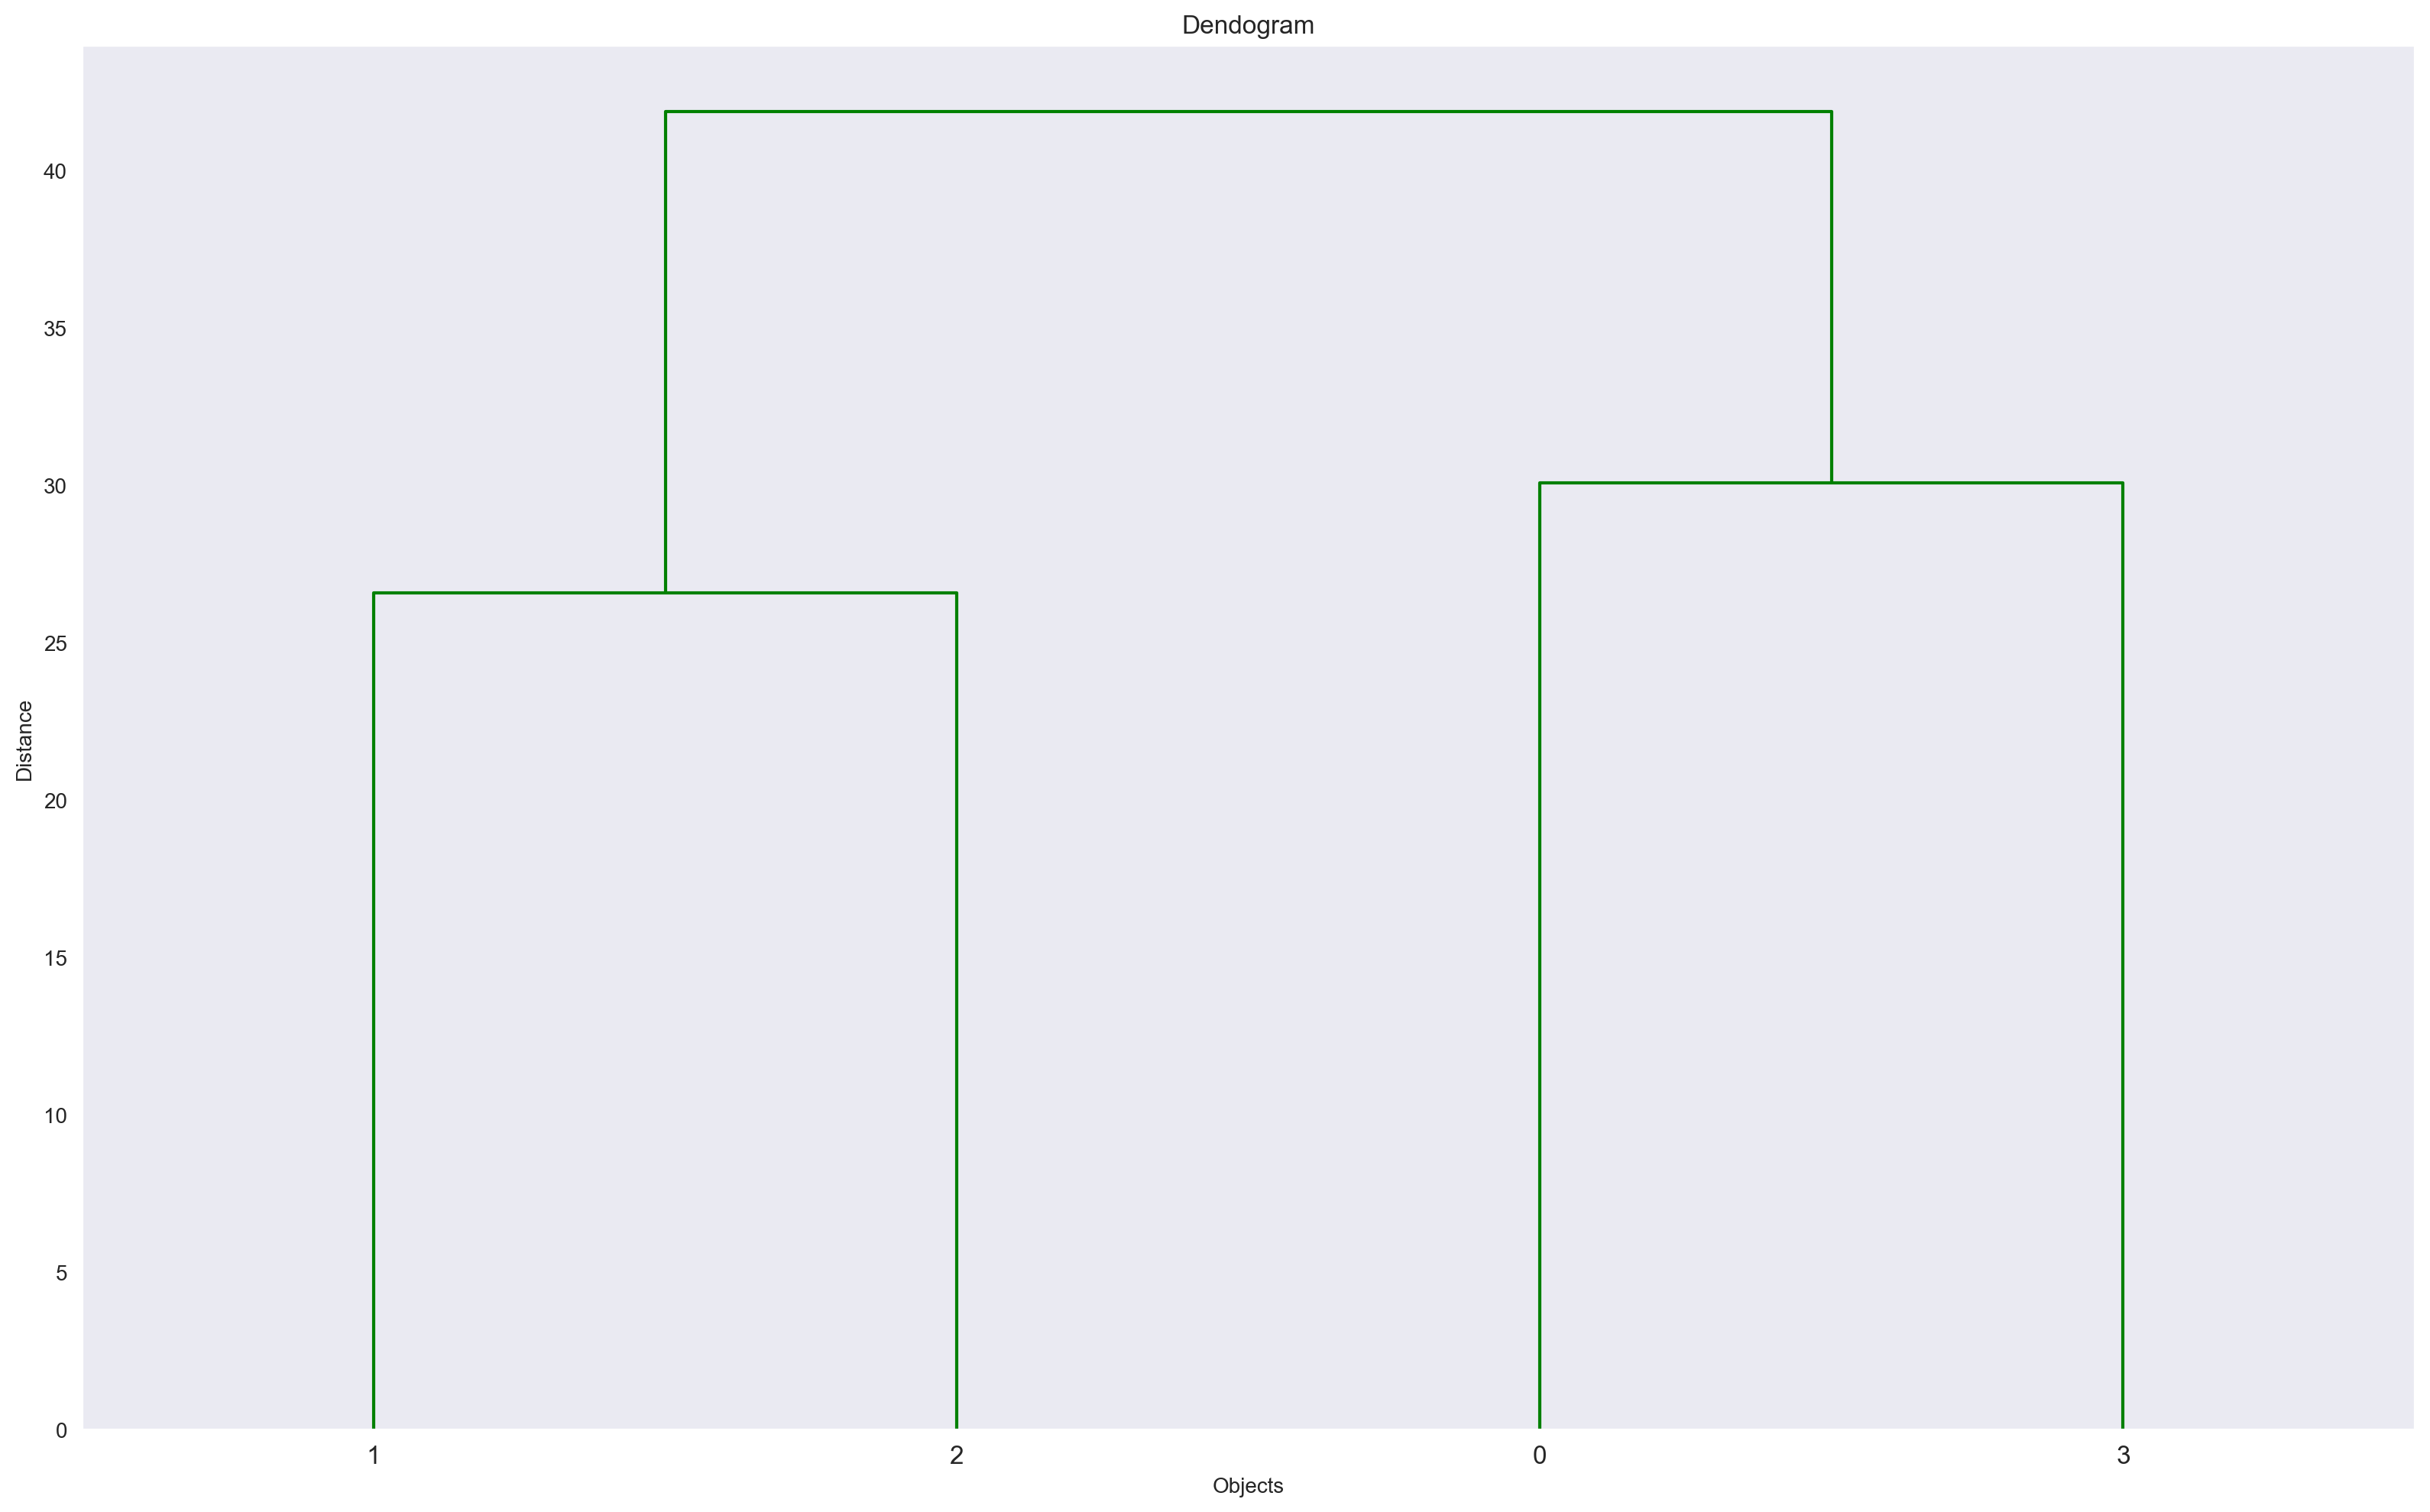

In [37]:
# Dendrogram
model = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean', compute_distances=True)

plot_dendrogram(data=features_df[-1],
                model=model,
                color_threshold=60)

In [38]:
# Train TimeSeriesKMeans with MDS
kmeans_model = TimeSeriesKMeans(n_clusters=5, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)
cluster_labels = kmeans_model.fit_predict(data_mds)

ts_clustered = [ scaled_ts[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

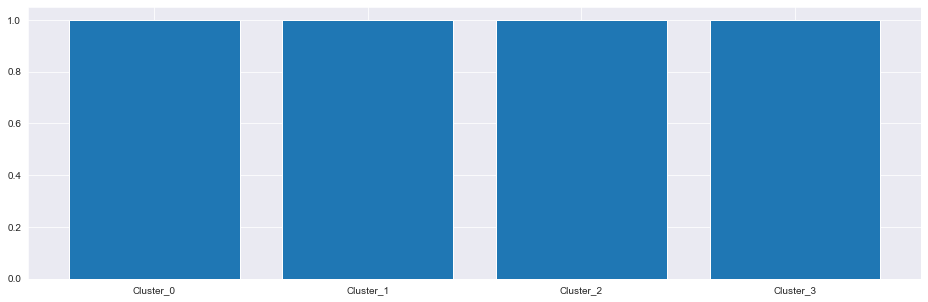

In [39]:
# Objects distribution in the obtained clusters 
labels = [f'Cluster_{i}' for i in range(len(ts_clustered))]
samples_in_cluster = [val.shape[0] for val in ts_clustered]

plt.figure(figsize=(16,5))
plt.bar(labels, samples_in_cluster);

In [40]:
def plot_cluster_ts(current_cluster):
    """
    Plots time series in a cluster 

    current_cluster: np.array
        Cluster with time series 
    Returns:
    -------
    None 
    """
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/3)),3,
        figsize=(45, 3*int(np.ceil(current_cluster.shape[0]/3)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for indx, series in enumerate(current_cluster):
        ax[indx].plot(series)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show();

==========Cluster number: 0==========


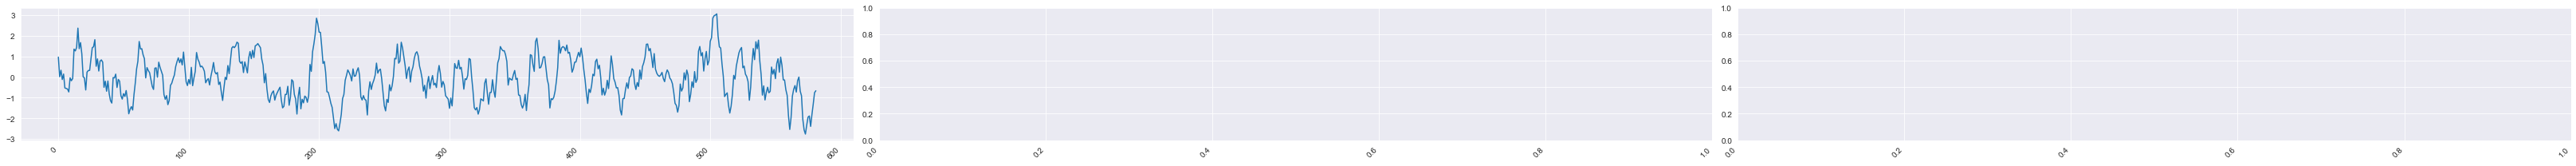

==========Cluster number: 1==========


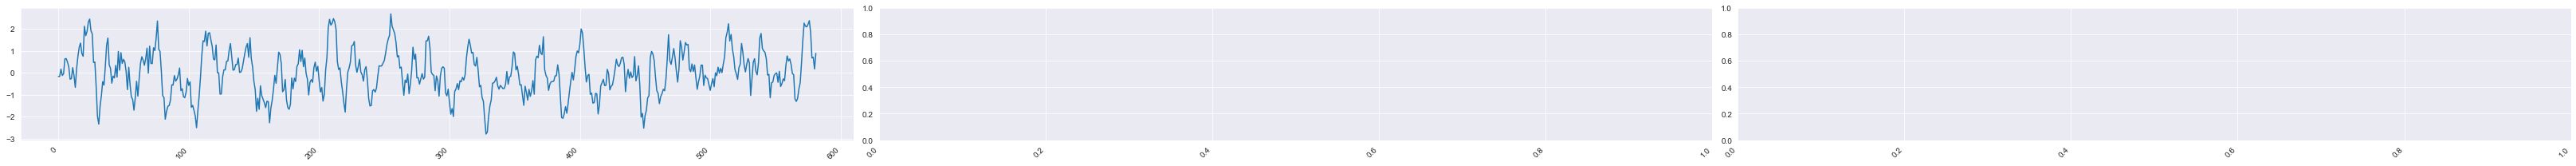

==========Cluster number: 2==========


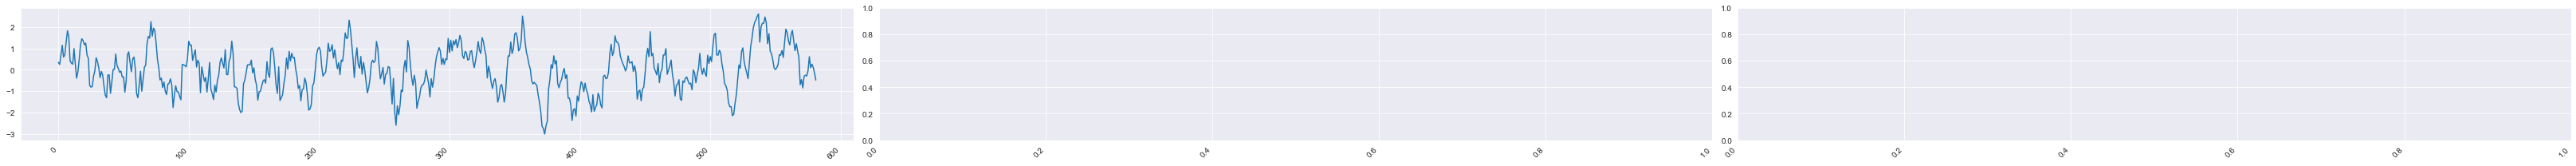

==========Cluster number: 3==========


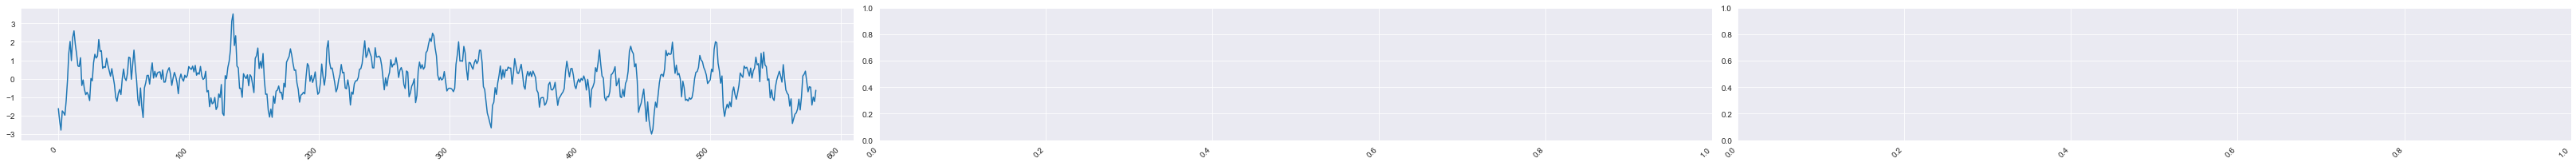

In [41]:
for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(ts_clustered[cluster])

In [42]:
# Closest Series to Cluster Centroid
closest_clusters_indxs = [np.argmin([np.linalg.norm(cluster_center - point, ord=2) for point in data_mds]) \
                                                                        for cluster_center in kmeans_model.cluster_centers_]

closest_ts = scaled_ts[closest_clusters_indxs, :]

In [43]:
# DBA
dba_ts = [dtw_barycenter_averaging(cluster_serieses, max_iter=10, verbose=True) for cluster_serieses in ts_clustered]

Attempt 1
[DBA] epoch 1, cost: 0.000
[DBA] epoch 2, cost: 0.000
Attempt 1
[DBA] epoch 1, cost: 0.000
[DBA] epoch 2, cost: 0.000
Attempt 1
[DBA] epoch 1, cost: 0.000
[DBA] epoch 2, cost: 0.000
Attempt 1
[DBA] epoch 1, cost: 0.000
[DBA] epoch 2, cost: 0.000


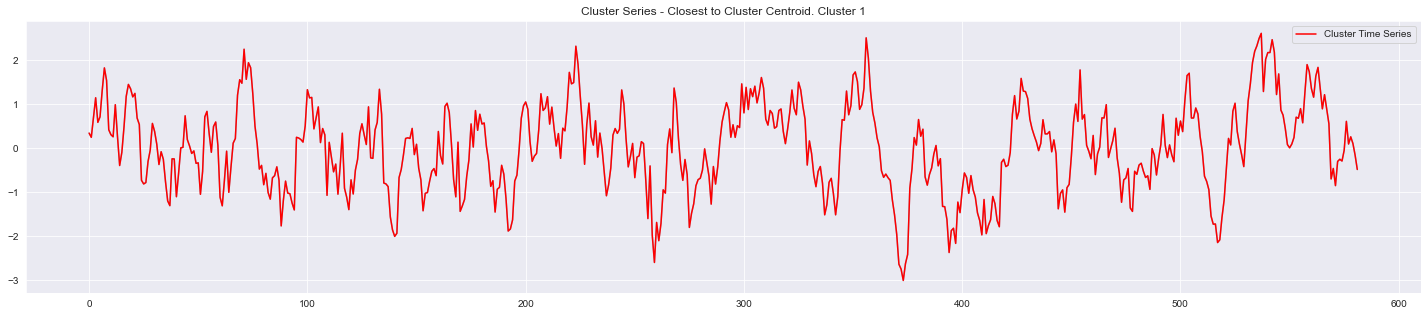

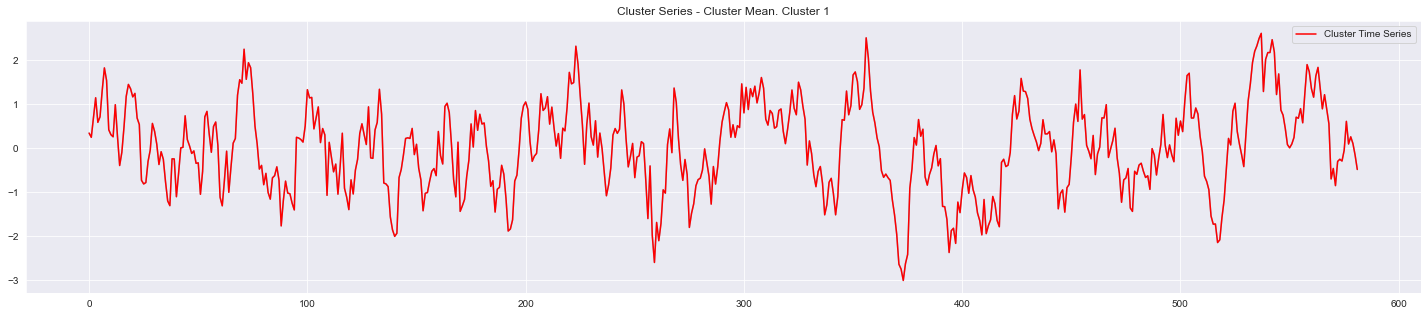

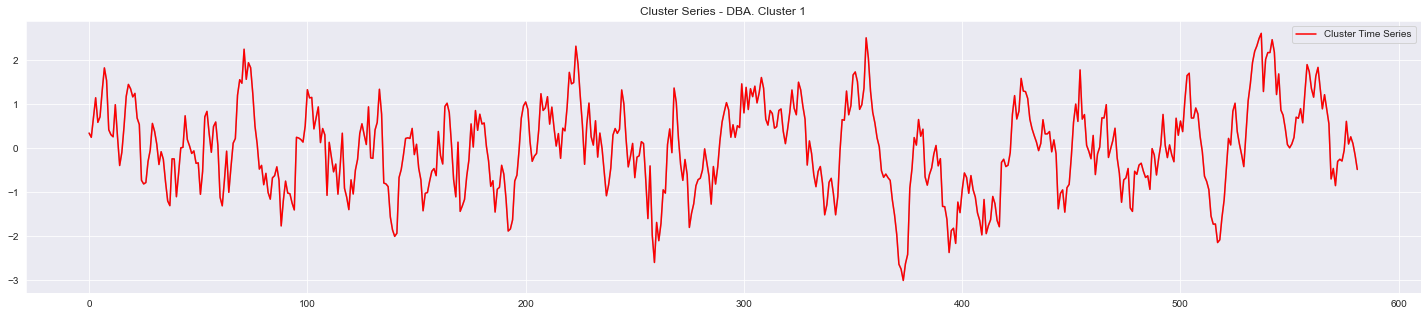

In [44]:
CLUSTER_N = 2

plt.figure(figsize=(25, 5))
plt.plot(ts_clustered[CLUSTER_N].T,  alpha = 0.4) # all series in the cluster_1
plt.plot(closest_ts[CLUSTER_N], c = 'r', label='Cluster Time Series')
plt.title('Cluster Series - Closest to Cluster Centroid. Cluster 1')
plt.legend();

plt.figure(figsize=(25, 5))
plt.plot(ts_clustered[CLUSTER_N].T,  alpha = 0.4) 
plt.plot(np.mean(ts_clustered[CLUSTER_N], axis=0), c = 'r', label='Cluster Time Series')
plt.title('Cluster Series - Cluster Mean. Cluster 1')
plt.legend();

plt.figure(figsize=(25, 5))
plt.plot(ts_clustered[CLUSTER_N].T,  alpha = 0.4) 
plt.plot(dba_ts[CLUSTER_N], c = 'r', label='Cluster Time Series')
plt.title('Cluster Series - DBA. Cluster 1')
plt.legend();

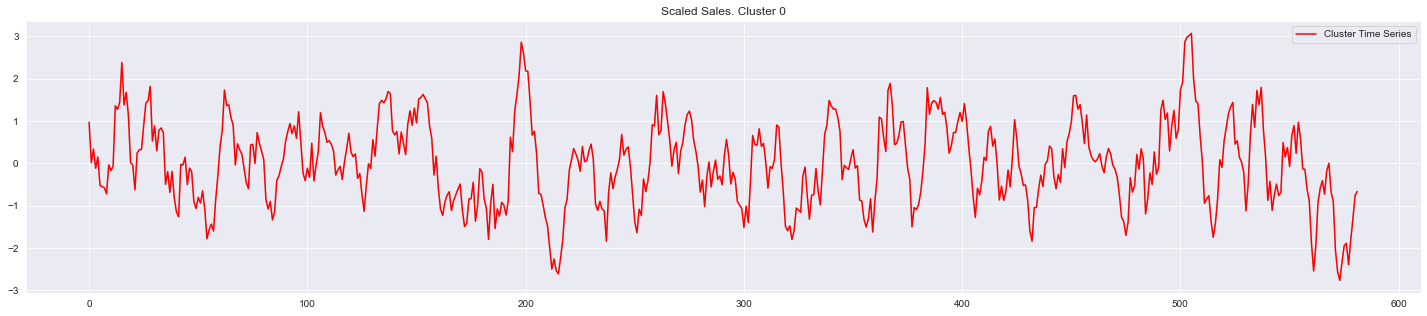

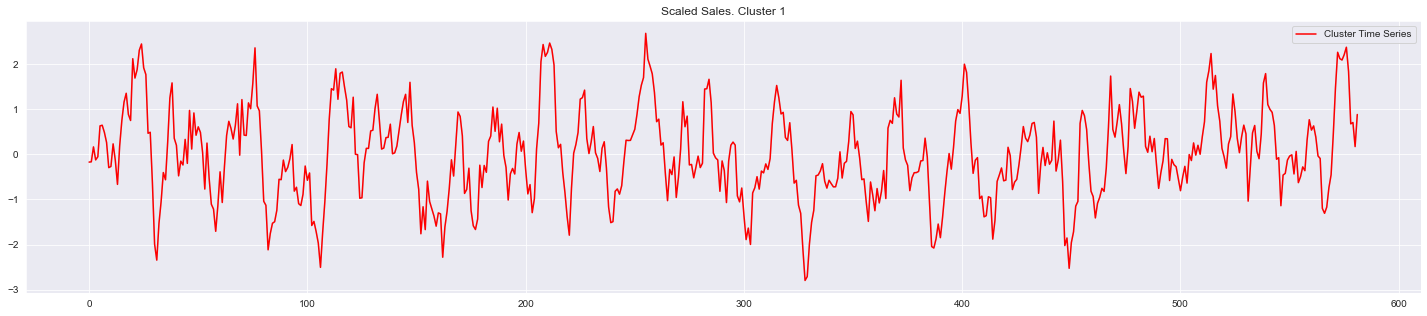

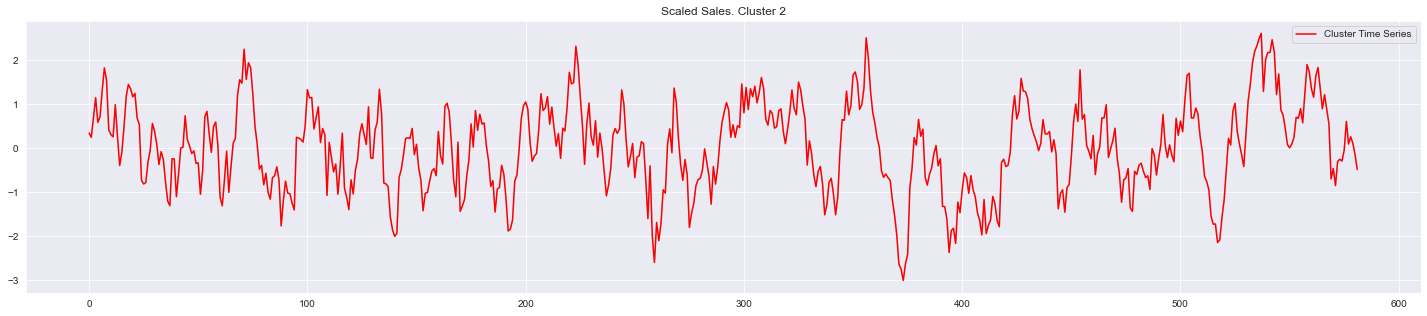

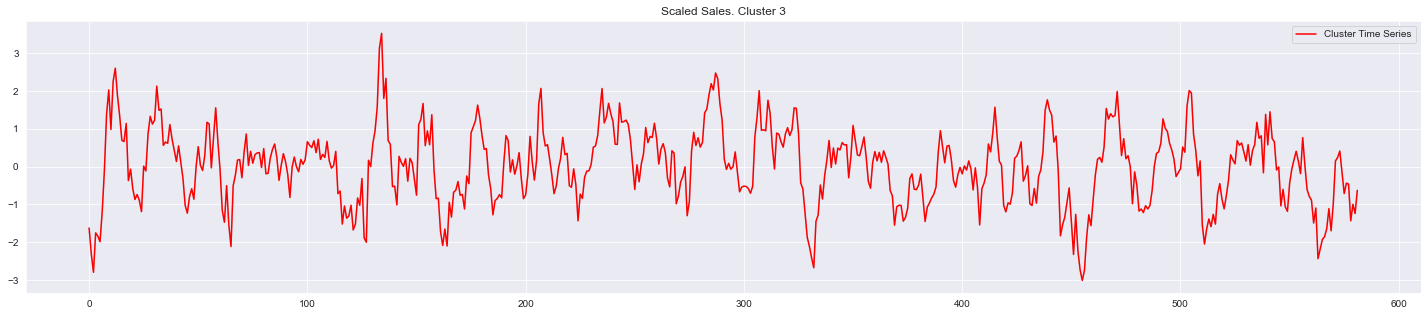

In [45]:
for indx, series in enumerate(dba_ts):
    plt.figure(figsize=(25, 5))
    plt.plot(ts_clustered[indx].T,  alpha = 0.15)
    plt.plot(series, c = 'r', label='Cluster Time Series')
    plt.title(f'Scaled Sales. Cluster {indx}')
    plt.legend();

#### now the problem

In [3]:
!pip install torch torchvision

In [4]:
!pip install plotly

In [46]:
os.chdir('./timeseries-clustering-vae')

In [47]:
from vrae.vrae import VRAE
from vrae.utils import *

import torch
import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

In [61]:
vrae_df = scaled_ts.copy()
dload = '/content/timeseries_clustering_vae/' 

In [62]:
# Model Params
hidden_size = 50
hidden_layer_depth = 1
latent_length = 20
batch_size = 2
learning_rate = 0.005
n_epochs = 40
dropout_rate = 0.1
optimizer = 'Adam' # Adam/SGD
cuda = True # Train on GPU
print_every=30
clip = True 
max_grad_norm=5
loss = 'MSELoss' # SmoothL1Loss/MSELoss
block = 'LSTM' # LSTM/GRU


In [63]:
# We don't use test_df, create train_df using all the data we have
X_train = np.expand_dims(scaled_ts, -1)
train_dataset = TensorDataset(torch.from_numpy(X_train))

sequence_length = X_train.shape[1] 
number_of_features = X_train.shape[2] 

In [65]:
X_train

array([[[-0.17263105],
        [-0.16635174],
        [ 0.16430071],
        ...,
        [ 0.70493525],
        [ 0.17134185],
        [ 0.8820143 ]],

       [[ 0.97073164],
        [ 0.01731044],
        [ 0.33473922],
        ...,
        [-1.30746405],
        [-0.75617209],
        [-0.66229381]],

       [[-1.62261391],
        [-2.3068938 ],
        [-2.79300597],
        ...,
        [-0.99699584],
        [-1.24044327],
        [-0.62847354]],

       [[ 0.33906996],
        [ 0.24327793],
        [ 0.70435907],
        ...,
        [ 0.10175411],
        [-0.16232046],
        [-0.4885399 ]]])

In [66]:
train_dataset

In [67]:
# Model Creation 
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

In [68]:
# import torch.utils.data as data
# # Create a DataLoader for the training dataset
# batch_size = 32  # Set your desired batch size
# train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Check if the train_loader has data
# if len(train_loader) == 0:
#     print("Training loader is empty. No data to train on.")
# else:
#     # Train the VRAE model
#     vrae.fit(train_loader)

In [70]:
%%time 

vrae.fit(train_dataset)

Epoch: 0
Average loss: 2296.5712
Epoch: 1
Average loss: 2332.0444
Epoch: 2
Average loss: 2274.0862
Epoch: 3
Average loss: 2441.0458
Epoch: 4
Average loss: 2308.3132
Epoch: 5
Average loss: 2304.0918
Epoch: 6
Average loss: 2298.6984
Epoch: 7
Average loss: 2287.4362
Epoch: 8
Average loss: 2287.0435
Epoch: 9
Average loss: 2294.9136
Epoch: 10
Average loss: 2287.1222
Epoch: 11
Average loss: 2286.6312
Epoch: 12
Average loss: 2285.2319
Epoch: 13
Average loss: 2283.7279
Epoch: 14
Average loss: 2294.2113
Epoch: 15
Average loss: 2295.3599
Epoch: 16
Average loss: 2291.6295
Epoch: 17
Average loss: 2289.2288
Epoch: 18
Average loss: 2288.6876
Epoch: 19
Average loss: 2282.9617
Epoch: 20
Average loss: 2285.4860
Epoch: 21
Average loss: 2306.5613
Epoch: 22
Average loss: 2303.3625
Epoch: 23
Average loss: 2298.9106
Epoch: 24
Average loss: 2280.5265
Epoch: 25
Average loss: 2293.6429
Epoch: 26
Average loss: 2291.6165
Epoch: 27
Average loss: 2292.8973
Epoch: 28
Average loss: 2290.8319
Epoch: 29
Average loss: 

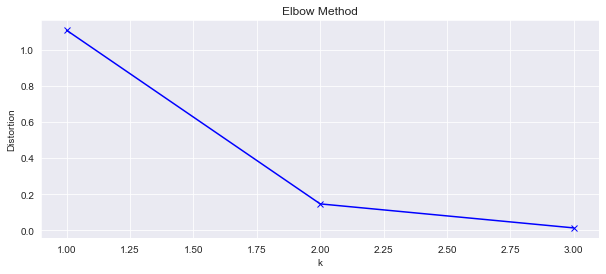

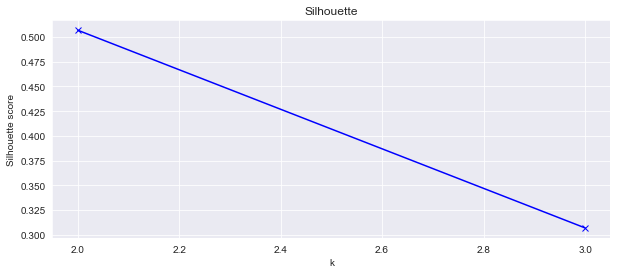

In [71]:
# Get embeddings
embeddings = vrae.transform(train_dataset)

# Cluster the embeddings
get_kmeans_results(data=embeddings, max_clusters=3, metric='euclidean', seed=SEED)

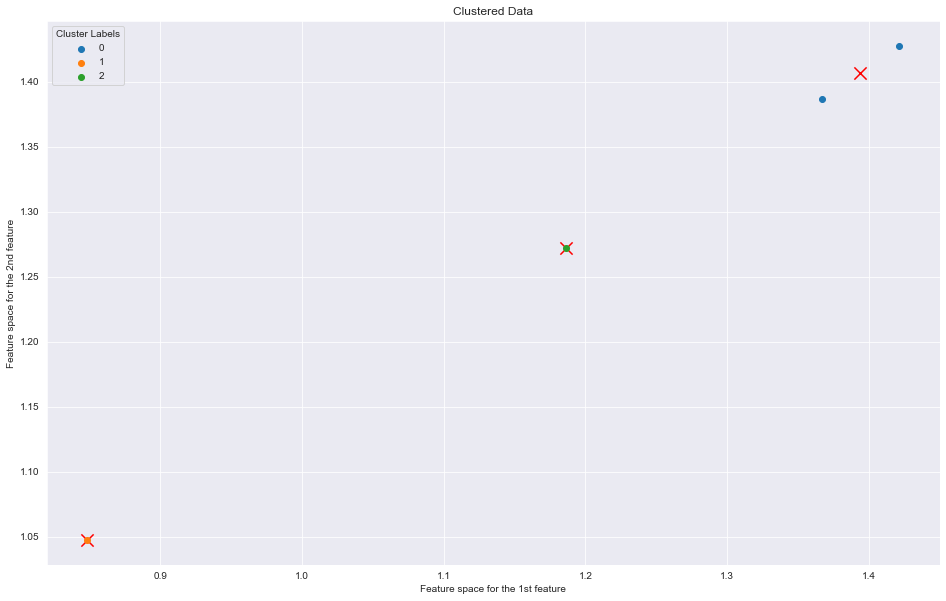

In [72]:
model = TimeSeriesKMeans(n_clusters=3, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)
 
plot_clusters(data=embeddings,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

In [73]:
import pickle

pd.to_pickle(model, 'model_storesales.pkl')